In [2]:
import os
import numpy as np
import pandas as pd
import open3d as o3d
import matplotlib.pyplot as plt



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# Function to create transects around target theta2 values
def create_transects_around_target_theta2(df, target_theta2_values, theta_range=1):
    transects = []
    for target_theta2 in target_theta2_values:
        transect = df[(df['theta'] >= target_theta2 - theta_range) & (df['theta'] <= target_theta2 + theta_range)]
        transects.append(transect)
    return transects

# Function to check for unassigned points
def check_unassigned_points(df, transects):
    assigned_points = pd.concat(transects)
    unassigned_points = df[~df.index.isin(assigned_points.index)]
    return len(unassigned_points)

# Directory containing .pcd files
pcd_directory = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Lidar\Alignment_test\Test"

# Define the transformation matrix
transformation_matrix = np.array([
    [2.9116514e-05, 0.000371316622, -0.0009284431, (644.85302734375 + 85000)],
    [-1.1219916e-05, -0.000928656838, -0.000371753966, (992.743286132813 + 445000)],
    [-0.000999878626, 2.123348e-05, -2.2864835e-05, 0.827817559242],
    [0.0, 0.0, 0.0, 1.0]
])

# Define the target theta2 values for each transect
target_theta2_values = [97.2, 92.5, 90.0, 87.6, 84.9, 82.7, 80.4, 77.9, 75.7, 73.0, 70.9, 68.0, 66.0, 63.4, 60.9, 55.7]

# Initialize an empty DataFrame to store all transformed data
all_transformed_data = pd.DataFrame(columns=['timestamp', 'x', 'y', 'z'])

# Loop through each .pcd file in the directory
for filename in os.listdir(pcd_directory):
    if filename.endswith(".PCD"):
        file_path = os.path.join(pcd_directory, filename)
        print('file found!')

        # Load point cloud
        pcd = o3d.io.read_point_cloud(file_path)

        # Extract points as a NumPy array
        xyz = np.asarray(pcd.points)

        # Convert to spherical coordinates with the z-axis as the reference axis
        x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
        rho = np.sqrt(x**2 + y**2 + z**2)
        phi = np.arctan2(y, x)
        theta_degrees = np.degrees(np.arccos(z / rho))

        # Create a DataFrame to store the point cloud data along with theta values
        point_cloud_df = pd.DataFrame({'x': x, 'y': y, 'z': z, 'theta': theta_degrees})

        # Generate transects with theta2 values around the specified target values with increased range
        transects = create_transects_around_target_theta2(point_cloud_df, target_theta2_values, theta_range=1)

        # Rename the transects starting from 1 going to 16
        transect_names = [f'Transect {i}' for i in range(1, 17)]
        transect_dict = dict(zip(transect_names, transects))

        # Count the number of points in each transect
        transect_point_counts = {name: len(transect) for name, transect in transect_dict.items()}

        # Check for unassigned points
        unassigned_points_count = check_unassigned_points(point_cloud_df, transects)
        if unassigned_points_count > 0:
            print(f"Unassigned points count: {unassigned_points_count}")

        # Remove the 'theta' column from each transect DataFrame
        for name in transect_dict:
            transect_dict[name] = transect_dict[name].drop(columns=['theta'])

        # Select Transect 3 for transformation 0 degree transect
        A = 3
        transect_A = transect_dict[f'Transect {A}']

        # Convert transect DataFrame to NumPy array
        transect_xyz = transect_A[['x', 'y', 'z']].values

        # Apply the transformation matrix
        transect_xyz_homogeneous = np.hstack((transect_xyz, np.ones((transect_xyz.shape[0], 1))))
        transect_xyz_transformed = transect_xyz_homogeneous.dot(transformation_matrix.T)[:, :3]

        # Create a DataFrame for the transformed transect
        transect_transformed_df = pd.DataFrame(transect_xyz_transformed, columns=['x', 'y', 'z'])

        # Compute the translation back offsets for X and Y only
        translation_back = np.eye(4)
        translation_back[0, 3] = -transformation_matrix[0, 3]
        translation_back[1, 3] = -transformation_matrix[1, 3]

        # Apply the translation back to the origin for X and Y
        transect_xyz_homogeneous = np.hstack((transect_transformed_df[['x', 'y', 'z']].values, np.ones((transect_transformed_df.shape[0], 1))))
        transect_xyz_transformed = transect_xyz_homogeneous.dot(translation_back.T)[:, :3]
        transect_transformed_df = pd.DataFrame(transect_xyz_transformed, columns=['x', 'y', 'z'])

        # Extract the rotation angle around the Z-axis
        theta_z = np.arctan2(transformation_matrix[1, 0], transformation_matrix[0, 0])

        # Create a reverse rotation matrix for the Z-axis
        cos_theta_z = np.cos(theta_z)
        sin_theta_z = np.sin(theta_z)
        rotation_z_matrix = np.array([
            [cos_theta_z, -sin_theta_z, 0, 0],
            [sin_theta_z, cos_theta_z,  0, 0],
            [0,           0,            1, 0],
            [0,           0,            0, 1]
        ])

        # Apply the reverse rotation around the Z-axis
        transect_xyz_homogeneous = np.hstack((transect_transformed_df[['x', 'y', 'z']].values, np.ones((transect_transformed_df.shape[0], 1))))
        transect_xyz_transformed = transect_xyz_homogeneous.dot(rotation_z_matrix.T)[:, :3]
        transect_transformed_df = pd.DataFrame(transect_xyz_transformed, columns=['x', 'y', 'z'])

        # Extract the last 17 digits of the filename as the timestamp
        timestamp = filename[-21:-4]  # Adjusted to extract the correct part of the filename
        transect_transformed_df['timestamp'] = timestamp

        # Append the transformed data to the all_transformed_data DataFrame
        all_transformed_data = pd.concat([all_transformed_data, transect_transformed_df], ignore_index=True)

# Save all transformed data to a single CSV file
output_csv_path = os.path.join(pcd_directory, 'all_transformed_data.csv')
all_transformed_data.to_csv(output_csv_path, index=False)

print(f"All transformed data saved to: {output_csv_path}")


file found!
file found!
file found!
file found!
file found!
file found!
All transformed data saved to: C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Lidar\Alignment_test\Test\all_transformed_data.csv


C:\Users\ruro\AppData\Local\Temp\ipykernel_28276\3325380185.py:119: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_transformed_data = pd.concat([all_transformed_data, transect_transformed_df], ignore_index=True)


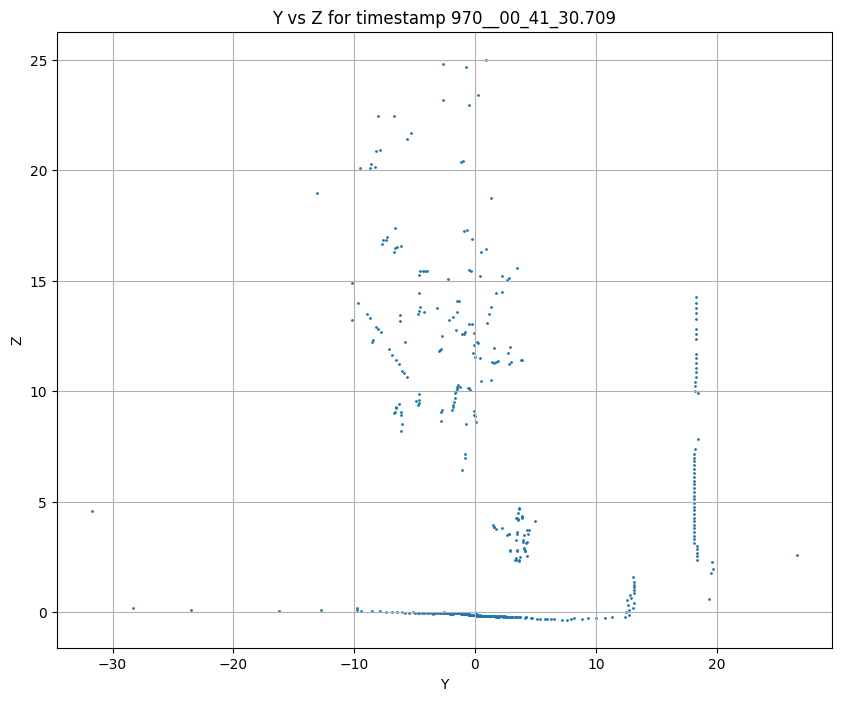

In [4]:
# Plot y vs z for a specific timestamp
specific_timestamp = '970__00_41_30.709'  # Replace with the desired timestamp
filtered_data = all_transformed_data[all_transformed_data['timestamp'] == specific_timestamp]

plt.figure(figsize=(10, 8))
plt.scatter(filtered_data['y'], filtered_data['z'], s=1)
plt.xlabel('Y')
plt.ylabel('Z')
plt.title(f'Y vs Z for timestamp {specific_timestamp}')
plt.grid(True)
plt.show()

C:\Users\ruro\AppData\Local\Temp\ipykernel_28276\2414776216.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_timestamps))


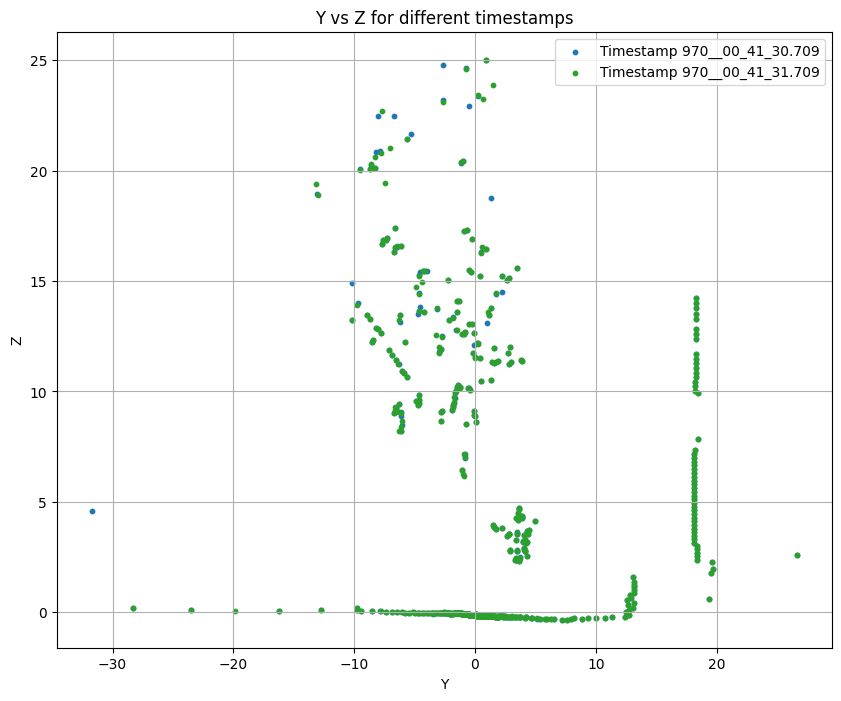

In [5]:
# Plot y vs z for each different timestamp in the CSV file
unique_timestamps = all_transformed_data['timestamp'].unique()
colors = plt.cm.get_cmap('tab20', len(unique_timestamps))

plt.figure(figsize=(10, 8))

# Loop through every 4th unique timestamp
for i, timestamp in enumerate(unique_timestamps[::4]):
    filtered_data = all_transformed_data[all_transformed_data['timestamp'] == timestamp]
    plt.scatter(filtered_data['y'], filtered_data['z'], color=colors(i), label=f'Timestamp {timestamp}', s=10)

plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Y vs Z for different timestamps')
plt.grid(True)
plt.legend()
plt.show()